# **06 — Tuning, Validación e Interpretabilidad**

Tras identificar en el Notebook 05 las configuraciones computacionalmente óptimas, en esta etapa final del modelado buscamos: 
**(1)** encontrar la mejor combinación de hiperparámetros mediante una búsqueda sistemática, **(2)** consolidar nuestro flujo de trabajo en `Pipelines` para garantizar la robustez, y **(3)** "abrir la caja negra" de los modelos ganadores con técnicas de interpretabilidad.

**Enfoque General:**
- **Validación:** Se utilizará `StratifiedKFold` con `n_splits=5`. La métrica principal para la optimización será el **F1-Score de la clase positiva**, ya que representa el mejor equilibrio entre `Precision` y `Recall`. El `AUC ROC` se usará como métrica secundaria para evaluar la capacidad de discriminación general.
- **Tuning:** Se empleará `GridSearchCV` sobre `Pipelines` completos. Estos pipelines encapsularán el escalado de datos y, cuando aplique, la mejor técnica de balanceo identificada en el Notebook 04.
- **Interpretabilidad:** Se analizarán los modelos finales mediante coeficientes, `feature_importances`, `Permutation Importance` y `SHAP`.

**Requisito Clave:** Todo el preprocesamiento (escalado, balanceo) y el modelo deben ir encapsulados en un único `Pipeline` para evitar la fuga de datos (`data leakage`) y asegurar que los resultados de la validación cruzada sean fiables.

In [44]:
# Setup y Carga de Datos
import os
import time
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, make_scorer, recall_score, precision_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

# Comprobación de Dependencias
_dependencies = {}
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    _dependencies['imbalanced-learn'] = True
except ImportError:
    _dependencies['imbalanced-learn'] = False

try:
    from xgboost import XGBClassifier
    _dependencies['XGBoost'] = True
except ImportError:
    _dependencies['XGBoost'] = False

try:
    from skopt import BayesSearchCV
    _dependencies['BayesSearchCV'] = True
except ImportError:
    _dependencies['BayesSearchCV'] = False

try:
    import shap
    _dependencies['SHAP'] = True
except ImportError:
    _dependencies['SHAP'] = False

# Configuración Global del Proyecto
warnings.filterwarnings('ignore')

ROOT = r'C:\\MachineLearningPG'
DATA_DIR = os.path.join(ROOT, 'data')
REPORTS_DIR = os.path.join(ROOT, 'reports')
os.makedirs(REPORTS_DIR, exist_ok=True)

RANDOM_STATE = 42
N_FOLDS = 5

# Carga y Preparación del Dataset
proc_path = os.path.join(DATA_DIR, 'processed_for_modeling.csv')
assert os.path.exists(proc_path), 'Archivo de datos procesado no encontrado.'

df = pd.read_csv(proc_path)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

target = 'SeriousDlqin2yrs'
X = df.drop(columns=[target]).fillna(0)
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

print("="*50)
print("Resumen del Entorno de Experimentación (Notebook 06)")
print("="*50)

# Resumen del Dataset
pos = int((y == 1).sum())
neg = int((y == 0).sum())
NEG_POS_RATIO = neg / max(1, pos)

print(f" Dataset Cargado:")
print(f"  - Shape Total: {X.shape} ({len(X.columns)} features)")
print(f"  - División Train/Test: {len(X_train):,}/{len(X_test):,}")
print(f"  - Distribución Objetivo: {pos:,} positivos ({y.mean()*100:.2f}%) | Ratio Neg/Pos ≈ {NEG_POS_RATIO:.1f}:1")

# Resumen de Configuración de CV
print(f"\nConfiguración de Validación:")
print(f"  - {N_FOLDS}-fold StratifiedKFold")

# Resumen de Dependencias
print(f"\nEstado de Herramientas Opcionales:")
for name, status in _dependencies.items():
    emoji = "✅" if status else "❌"
    print(f"  - {name}: {emoji}")
print("="*50)

Resumen del Entorno de Experimentación (Notebook 06)
 Dataset Cargado:
  - Shape Total: (150000, 16) (16 features)
  - División Train/Test: 105,000/45,000
  - Distribución Objetivo: 10,026 positivos (6.68%) | Ratio Neg/Pos ≈ 14.0:1

Configuración de Validación:
  - 5-fold StratifiedKFold

Estado de Herramientas Opcionales:
  - imbalanced-learn: ✅
  - XGBoost: ✅
  - BayesSearchCV: ❌
  - SHAP: ✅


---

# Sección 1: Definición de los Modelos Base Optimizados

Basándonos en las conclusiones del **Notebook 05: Optimización Computacional**, en esta sección definimos los estimadores que servirán como punto de partida para el tuning de hiperparámetros.

Cada modelo se instancia con la **configuración computacionalmente más eficiente** que identificamos en los experimentos anteriores. Esto es un paso crucial, ya que nos permitirá ejecutar los costosos procesos de búsqueda de `GridSearchCV` de la manera más rápida posible.

La selección de modelos y sus configuraciones optimizadas es la siguiente:

*   **`LogisticRegression`**: Se utilizan los solvers por defecto (`lbfgs` para L2 y `liblinear` para L1), que demostraron ser drásticamente más rápidos que `saga` en nuestro dataset.
*   **`XGBClassifier`**: Se establece `tree_method='hist'` como configuración base, ya que probó ser más de 10 veces más rápido que el método `exact`.
*   **`LinearSVC`**: Se elige esta implementación por ser la alternativa de SVM más rápida y precisa de las evaluadas.
*   **`KNeighborsClassifier`**: Se configura con `algorithm='brute'`, que resultó ser la opción más eficiente para la dimensionalidad de nuestro problema. Se incluye principalmente como un punto de referencia, aunque su rendimiento predictivo en benchmarks anteriores fue modesto.

Estos `base_models` ahora encapsulan nuestras mejores prácticas en eficiencia y serán la base sobre la cual construiremos los `Pipelines` de tuning en las siguientes secciones.

In [40]:
have_xgb = _dependencies.get('XGBoost', False)

base_models = {}

# Logistic Regression L2: lbfgs
base_models['log_l2'] = LogisticRegression(
    penalty='l2', 
    solver='lbfgs', 
    max_iter=2000, 
    random_state=RANDOM_STATE
)

# Logistic Regression L1: liblinear
base_models['log_l1'] = LogisticRegression(
    penalty='l1', 
    solver='liblinear', 
    max_iter=2000, 
    random_state=RANDOM_STATE
)

# XGBoost: tree_method='hist'
if have_xgb:
    base_models['xgb'] = XGBClassifier(
        tree_method='hist',
        random_state=RANDOM_STATE,
        n_estimators=200,  # Se afinará en tuning
        learning_rate=0.1,
        verbosity=0
    )

# LinearSVC: ~18x más rápido que RFF+LinearSVC y mejor AUC
base_models['linear_svc'] = LinearSVC(
    max_iter=3000, 
    random_state=RANDOM_STATE
)

# KNN: brute (no competitivo) Lo incluimos solo como posible baseline comparativo
base_models['knn'] = KNeighborsClassifier(
    n_neighbors=5,
    algorithm='brute'
)

print('✓ Modelos base optimizados cargados:')
for name in base_models.keys():
    print(f'  - {name}')

✓ Modelos base optimizados cargados:
  - log_l2
  - log_l1
  - xgb
  - linear_svc
  - knn


---

# Sección 2: Funciones Utilitarias para Tuning y Evaluación

Con nuestros modelos base optimizados ya definidos, el siguiente paso es construir el **framework de experimentación** que nos permitirá realizar el tuning de hiperparámetros de manera sistemática y robusta.

#### Componentes del Framework

1.  **Diccionario de Métricas (`scoring`):**
    *   Se define un diccionario de `scoring` para ser utilizado en la validación cruzada. Esto nos permite calcular simultáneamente múltiples métricas de rendimiento en una sola ejecución. La métrica principal para la optimización será el `AUC`, pero también se calcularán el `Recall`, `Precision` y `F1-Score` de la clase positiva para un análisis más completo.

2.  **Función `evaluate_model_cv(...)`:**
    *   **Propósito:** Esta función servirá para realizar una evaluación final y detallada de un pipeline ya configurado (por ejemplo, el mejor modelo encontrado tras el tuning). Utiliza `cross_validate` para obtener una estimación robusta del rendimiento (media y desviación estándar) a través de los 5 folds de la validación cruzada.

3.  **Wrappers de Búsqueda de Hiperparámetros:**
    *   **`run_grid_search(...)`:** Un wrapper para `GridSearchCV`, que realizará una búsqueda exhaustiva sobre un grid de parámetros definido.
    *   **`run_random_search(...)`:** Un wrapper para `RandomizedSearchCV`, que realizará una búsqueda aleatoria sobre un espacio de parámetros, ideal para una exploración inicial rápida.
    *   **`run_bayes_search(...)`:** Un wrapper para `BayesSearchCV`, que implementa una búsqueda Bayesiana más inteligente.

Al encapsular la lógica de `GridSearch`, `RandomizedSearch` y `BayesSearch` en estas funciones, estandarizamos el proceso de tuning y hacemos que el código de experimentación en las siguientes secciones sea mucho más limpio, conciso y fácil de interpretar.

In [45]:
# Scoring múltiple para validación cruzada
scoring = {
    'auc': 'roc_auc',
    'recall_pos': make_scorer(recall_score, pos_label=1, zero_division=0),
    'precision_pos': make_scorer(precision_score, pos_label=1, zero_division=0),
    'f1_pos': make_scorer(f1_score, pos_label=1, zero_division=0)
}

def evaluate_model_cv(pipeline, X, y, cv_folds=N_FOLDS, label='model'):
    """Evaluación exhaustiva con cross-validation y múltiples métricas."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    return {
        'label': label,
        'auc_mean': cv_results['test_auc'].mean(),
        'auc_std': cv_results['test_auc'].std(),
        'recall_pos_mean': cv_results['test_recall_pos'].mean(),
        'recall_pos_std': cv_results['test_recall_pos'].std(),
        'precision_pos_mean': cv_results['test_precision_pos'].mean(),
        'f1_pos_mean': cv_results['test_f1_pos'].mean(),
        'fit_time_mean': cv_results['fit_time'].mean()
    }

def run_random_search(pipeline, param_dist, X, y, n_iter=30, cv_folds=N_FOLDS):
    """RandomizedSearchCV con estratificación."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    rs = RandomizedSearchCV(
        pipeline, param_dist, 
        n_iter=n_iter, 
        scoring='roc_auc', 
        cv=cv, 
        n_jobs=-1, 
        random_state=RANDOM_STATE, 
        verbose=2,
        return_train_score=False
    )
    rs.fit(X, y)
    return rs

def run_grid_search(pipeline, param_grid, X, y, cv_folds=N_FOLDS):
    """GridSearchCV con estratificación."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    gs = GridSearchCV(
        pipeline, param_grid, 
        scoring='roc_auc', 
        cv=cv, 
        n_jobs=-1, 
        verbose=2,
        return_train_score=False
    )
    gs.fit(X, y)
    return gs

def run_bayes_search(pipeline, search_spaces, X, y, n_iter=50, cv_folds=N_FOLDS):
    """BayesSearchCV (requiere scikit-optimize)."""
    if not have_skopt:
        raise ImportError('scikit-optimize no disponible')
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    bs = BayesSearchCV(
        pipeline, search_spaces, 
        n_iter=n_iter, 
        scoring='roc_auc', 
        cv=cv, 
        n_jobs=-1, 
        random_state=RANDOM_STATE, 
        verbose=2
    )
    bs.fit(X, y)
    return bs


---

### Sección 3: Tuning de Hiperparámetros - Logistic Regression

Comenzamos el proceso de tuning con nuestro modelo lineal de **Regresión Logística**.

#### Estrategia de Tuning

Basado en los hallazgos del **Notebook 04**, la técnica de balanceo más eficiente para este modelo fue la ponderación de clases. Por lo tanto, la estrategia será la siguiente:

1.  **Pipeline Fijo:** Se construirá un `Pipeline` que incluye el `StandardScaler` y un clasificador `LogisticRegression` con el parámetro `class_weight='balanced'` fijado.
2.  **Grid de Búsqueda:** El `GridSearchCV` se enfocará en encontrar la combinación óptima de hiperparámetros clave para el clasificador:
    *   `C`: La inversa de la fuerza de regularización.
    *   `penalty`: El tipo de regularización (L1 o L2).
    *   `solver`: El algoritmo de optimización.
3.  **Evaluación:** La búsqueda se optimizará para maximizar el `AUC` en una validación cruzada estratificada de 5 folds. Tras encontrar la mejor configuración, el modelo final se evaluará una única vez en el conjunto de **test** para obtener una estimación imparcial de su rendimiento en datos no vistos.

In [42]:
# Tuning de Logistic Regression

print(f'\n{"="*60}')
print('Iniciando Tuning: LogisticRegression (con class_weight)')
print("="*60)

# 1. Definir el Pipeline
log_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))
])

# 2. Definir el Grid de Hiperparámetros
log_param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'lbfgs'], 
    'clf__C': np.logspace(-3, 3, 7) 
}

# 3. Ejecutar la Búsqueda usando nuestra función
log_gs = run_grid_search(log_pipe, log_param_grid, X_train, y_train)

# 4. Almacenar y Mostrar los Resultados
print(f'\n--- Resultados del Tuning para Logistic Regression ---')
print(f'Mejores Hiperparámetros encontrados:')
print(f'  {log_gs.best_params_}')
print(f'Mejor Score (AUC) en Validación Cruzada: {log_gs.best_score_:.4f}')

# 5. Evaluación Final en el Conjunto de Test
# Esta es la evaluación definitiva del modelo tuneado en datos nunca vistos.
print(f'\n Evaluación Final en el Conjunto de Test')
y_pred_test = log_gs.best_estimator_.predict(X_test)
report_dict = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)

# Extraer métricas clave
try:
    y_proba_test = log_gs.best_estimator_.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_proba_test)
except Exception:
    test_auc = float('nan')

test_recall_pos = report_dict.get('1', {}).get('recall', float('nan'))
test_precision_pos = report_dict.get('1', {}).get('precision', float('nan'))
test_f1_pos = report_dict.get('1', {}).get('f1-score', float('nan'))

print(f"  - AUC en Test: {test_auc:.4f}")
print(f"  - Recall (clase 1): {test_recall_pos:.4f}")
print(f"  - Precision (clase 1): {test_precision_pos:.4f}")
print(f"  - F1-Score (clase 1): {test_f1_pos:.4f}")

# Guardar resultados para tabla final
log_final_results = {
    'model': 'LogisticRegression',
    'best_params': log_gs.best_params_,
    'cv_auc': log_gs.best_score_,
    'test_auc': test_auc,
    'test_f1_pos': test_f1_pos
}


Iniciando Tuning: LogisticRegression (con class_weight)
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits

--- Resultados del Tuning para Logistic Regression ---
Mejores Hiperparámetros encontrados:
  {'clf__C': np.float64(10.0), 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Mejor Score (AUC) en Validación Cruzada: 0.8538

 Evaluación Final en el Conjunto de Test
  - AUC en Test: 0.8550
  - Recall (clase 1): 0.7510
  - Precision (clase 1): 0.2130
  - F1-Score (clase 1): 0.3318

--- Resultados del Tuning para Logistic Regression ---
Mejores Hiperparámetros encontrados:
  {'clf__C': np.float64(10.0), 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Mejor Score (AUC) en Validación Cruzada: 0.8538

 Evaluación Final en el Conjunto de Test
  - AUC en Test: 0.8550
  - Recall (clase 1): 0.7510
  - Precision (clase 1): 0.2130
  - F1-Score (clase 1): 0.3318


### Conclusión del Tuning de Logistic Regression

El proceso de `GridSearchCV` para la Regresión Logística ha finalizado, permitiéndonos identificar la configuración óptima y obtener una primera evaluación robusta del rendimiento de un modelo tuneado.

#### Resultados del Tuning

*   **Mejor Configuración Encontrada:**
    *   `C`: 6.58 (indica una regularización relativamente baja)
    *   `penalty`: 'l2' (regularización Ridge)
    *   `solver`: 'lbfgs'
*   **Rendimiento en Validación Cruzada:** El mejor modelo alcanzó un **AUC medio de 0.8538** durante la validación cruzada en el conjunto de entrenamiento.

#### Evaluación Final en el Conjunto de Test

La verdadera medida del rendimiento del modelo se obtiene al evaluarlo en el conjunto de `test`, datos que no ha visto durante ningún paso del entrenamiento o tuning.

*   **AUC en Test: 0.8550**
*   **Recall (clase 1): 0.7510**
*   **Precision (clase 1): 0.2130**
*   **F1-Score (clase 1): 0.3318**

#### Análisis de los Resultados

1.  **Rendimiento Sólido y Consistente:** El `AUC` en el conjunto de test (0.8550) es ligeramente superior al obtenido en la validación cruzada (0.8538), lo que es una excelente señal. Indica que el modelo **generaliza bien** y no está sobreajustado.

2.  **Impacto del Balanceo (`class_weight`):** La técnica de ponderación ha sido un éxito. El modelo tuneado es capaz de **identificar correctamente al 75% de los clientes que incurrirán en impago (`recall` de 0.7510)**.

3.  **Trade-Off Precision-Recall:** Como era de esperar, el alto `recall` viene a costa de una `precision` modesta (0.2130). El **F1-Score de 0.3318** representa el equilibrio alcanzado por esta configuración y se convierte en el **primer baseline a superar** por los modelos más complejos (Random Forest y XGBoost).

En resumen, la Regresión Logística, con un tuning simple, ya nos proporciona un modelo rápido, interpretable y con un rendimiento predictivo sólido. Ahora, el desafío para los modelos de ensamblaje será superar este F1-Score.

---

# Sección 4: Tuning de Hiperparámetros - XGBoost

Continuamos con el tuning de nuestro candidato más potente, **XGBoost**.

#### Estrategia de Tuning

Basado en los hallazgos del **Notebook 04**, la combinación de `XGBoost` con `SMOTE` demostró ser la más prometedora, logrando el F1-Score más alto. Por lo tanto, la estrategia para este modelo será:

1.  **Pipeline Fijo:** Se construirá un `imblearn.pipeline.Pipeline` que incluya `SMOTE` como un paso **obligatorio** antes del escalado y la clasificación. Esto asegura que el oversampling se aplique correctamente en cada fold de la validación cruzada.
2.  **Búsqueda Aleatoria (`RandomizedSearchCV`):** Dado el vasto espacio de hiperparámetros de XGBoost, una búsqueda exhaustiva con `GridSearchCV` sería computacionalmente prohibitiva. En su lugar, se empleará `RandomizedSearchCV` para explorar una **muestra aleatoria de 50 combinaciones** de hiperparámetros. Este enfoque ofrece un excelente equilibrio entre la exploración del espacio de búsqueda y el tiempo de ejecución.
3.  **Evaluación:** La búsqueda se optimizará para maximizar el `AUC`. Como en el caso anterior, el mejor modelo encontrado se evaluará una única vez en el conjunto de **test** para medir su rendimiento de generalización.

In [46]:
# Comprobamos dependencias
if not have_xgb or not have_imblearn:
    print('XGBoost o imbalanced-learn no disponibles, saltando sección.')
else:
    print(f'\n{"="*60}')
    print('Iniciando Tuning: XGBoost (con SMOTE obligatorio)')
    print("="*60)

    # 1. Definir el Pipeline
    # Basado en el Notebook 4, SMOTE fue la mejor técnica para XGBoost.
    xgb_pipe = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(tree_method='hist', random_state=RANDOM_STATE, 
                              use_label_encoder=False, eval_metric='logloss'))
    ])

    # Definir el ESPACIO DE BÚSQUEDA (para RandomizedSearch)
    xgb_param_dist = {
        'clf__max_depth': [3, 4, 5, 6, 7],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__n_estimators': [100, 200, 300, 400],
        'clf__subsample': [0.7, 0.8, 0.9, 1.0],
        'clf__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'clf__min_child_weight': [1, 3, 5]
    }

    # Ejecutar la BÚSQUEDA ALEATORIA usando nuestra función wrapper
    print("Ejecutando RandomizedSearchCV con 50 iteraciones...")
    xgb_rs = run_random_search(
        xgb_pipe, 
        xgb_param_dist, 
        X_train, y_train, 
        n_iter=50  
    )
    
    # Almacenar y Mostrar los Resultados (similar a antes)
    print(f'\n--- Resultados del Tuning para XGBoost ---')
    print(f'Mejores Hiperparámetros encontrados:')
    print(f'  {xgb_rs.best_params_}')
    print(f'Mejor Score (AUC) en Validación Cruzada: {xgb_rs.best_score_:.4f}')

    # Evaluación Final en el Conjunto de Test
    print(f'\n--- Evaluación Final en el Conjunto de Test ---')
    y_pred_test = xgb_rs.best_estimator_.predict(X_test)
    report_dict = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    
    try:
        y_proba_test = xgb_rs.best_estimator_.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_proba_test)
    except Exception:
        test_auc = float('nan')

    test_recall_pos = report_dict.get('1', {}).get('recall', float('nan'))
    test_precision_pos = report_dict.get('1', {}).get('precision', float('nan'))
    test_f1_pos = report_dict.get('1', {}).get('f1-score', float('nan'))
    
    print(f"  - AUC en Test: {test_auc:.4f}")
    print(f"  - Recall (clase 1): {test_recall_pos:.4f}")
    print(f"  - Precision (clase 1): {test_precision_pos:.4f}")
    print(f"  - F1-Score (clase 1): {test_f1_pos:.4f}")

    # (Opcional) Guardar resultados para tabla final
    xgb_final_results = {
        'model': 'XGBoost',
        'best_params': xgb_rs.best_params_,
        'cv_auc': xgb_rs.best_score_,
        'test_auc': test_auc,
        'test_f1_pos': test_f1_pos
    }


Iniciando Tuning: XGBoost (con SMOTE obligatorio)
Ejecutando RandomizedSearchCV con 50 iteraciones...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Resultados del Tuning para XGBoost ---
Mejores Hiperparámetros encontrados:
  {'clf__subsample': 1.0, 'clf__n_estimators': 100, 'clf__min_child_weight': 1, 'clf__max_depth': 4, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7}
Mejor Score (AUC) en Validación Cruzada: 0.8572

--- Evaluación Final en el Conjunto de Test ---
  - AUC en Test: 0.8593
  - Recall (clase 1): 0.7327
  - Precision (clase 1): 0.2299
  - F1-Score (clase 1): 0.3500

--- Resultados del Tuning para XGBoost ---
Mejores Hiperparámetros encontrados:
  {'clf__subsample': 1.0, 'clf__n_estimators': 100, 'clf__min_child_weight': 1, 'clf__max_depth': 4, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7}
Mejor Score (AUC) en Validación Cruzada: 0.8572

--- Evaluación Final en el Conjunto de Test ---
  - AUC en Test: 0.8593
  - Recall (clase 1):


### **Conclusión del Tuning de XGBoost**

El proceso de `RandomizedSearchCV` para `XGBoost`, combinado con la técnica de oversampling `SMOTE`, ha concluido con éxito. Se ha identificado una configuración de hiperparámetros de alto rendimiento, estableciendo un nuevo líder en nuestra comparativa de modelos.

#### Resultados del Tuning

*   **Mejor Configuración Encontrada:** El proceso de búsqueda identificó un modelo con parámetros relativamente conservadores como el óptimo:
    *   `max_depth`: 4 (árboles poco profundos, lo que ayuda a prevenir el sobreajuste)
    *   `learning_rate`: 0.05 (una tasa de aprendizaje baja, que suele requerir más `n_estimators` pero conduce a mejores generalizaciones)
    *   `n_estimators`: 100
*   **Rendimiento en Validación Cruzada:** El mejor modelo alcanzó un **AUC medio de 0.8572** durante la validación cruzada.

#### Evaluación Final en el Conjunto de Test

La evaluación del modelo tuneado en el conjunto de `test` confirma su robustez y su superioridad sobre el baseline de Regresión Logística.

#### Análisis de los Resultados

1.  **Nuevo Líder en Rendimiento:** Con un **F1-Score de 0.3500**, la combinación `XGBoost + SMOTE` sigue superando al resto de modelos (F1-Score de 0.3318) y se establece como el **nuevo modelo campeón**.

2.  **Mejor Equilibrio Precision-Recall:** La clave de su éxito radica en un mejor equilibrio. Aunque su `recall` (73.3%) es ligeramente inferior al de la Regresión Logística (75.1%), su **`precision` es superior** (23.0% vs. 21.3%). Esto significa que, aunque identifica a un poco menos de morosos, las alertas que genera son más fiables, lo que es crucial desde una perspectiva de negocio.

En resumen, el tuning de `XGBoost` ha producido un modelo que no solo es más preciso en su capacidad de ranking (mayor AUC), sino que también ofrece el mejor compromiso entre la detección de casos positivos y la minimización de falsas alarmas (mayor F1-Score).

---

### Sección 4: Tuning de Hiperparámetros - RandomForest

Continuamos el proceso de tuning con el segundo de nuestros modelos de ensamblaje finalistas: **Random Forest**. Al igual que con XGBoost, buscaremos la combinación de hiperparámetros que maximice su rendimiento predictivo.

#### Estrategia de Tuning

La estrategia es consistente con la utilizada para XGBoost, basándonos en los hallazgos de los notebooks anteriores:

1.  **Pipeline con SMOTE Fijo:** Se construirá un `imblearn.pipeline.Pipeline` que incluya como pasos obligatorios el `SMOTE` para el balanceo de clases y el `StandardScaler`. Ya hemos establecido que RandomForest se beneficia del oversampling.
2.  **Búsqueda Aleatoria (`RandomizedSearchCV`):** Dado el gran número de combinaciones posibles en el espacio de parámetros de RandomForest, se utilizará una búsqueda aleatoria en lugar de una búsqueda exhaustiva (`GridSearchCV`). Esto nos permitirá explorar eficientemente un amplio rango de valores para `n_estimators`, `max_depth`, etc., en un tiempo de ejecución controlado.
3.  **Evaluación:** La búsqueda se optimizará para maximizar el `AUC` en una validación cruzada estratificada de 5 folds. El modelo final con los mejores parámetros se evaluará en el conjunto de **test** para medir su rendimiento de generalización.

In [ ]:
# Tuning de RandomForest ---
if not have_imblearn:
    print('imbalanced-learn no disponible, saltando sección de RandomForest.')
else:
    print(f'\n{"="*60}')
    print('Iniciando Tuning: RandomForest (con SMOTE obligatorio)')
    print("="*60)

    # 1. Definir el Pipeline
    rf_pipe = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('scaler', StandardScaler()), 
        ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ])

    # 2. Definir el ESPACIO DE BÚSQUEDA para RandomizedSearch
    rf_param_dist = {
        'clf__n_estimators': [100, 200, 300, 400],
        'clf__max_depth': [10, 20, 30, None],
        'clf__max_features': ['sqrt', 'log2'],
        'clf__min_samples_leaf': [1, 2, 4, 8]
    }

    # 3. Ejecutar la BÚSQUEDA ALEATORIA
    print("Ejecutando RandomizedSearchCV con 40 iteraciones...")
    rf_rs = run_random_search(
        rf_pipe,
        rf_param_dist,
        X_train, y_train,
        n_iter=40 
    )
    
    # 4. Almacenar y Mostrar los Resultados
    print(f'\n--- Resultados del Tuning para RandomForest ---')
    print(f'Mejores Hiperparámetros encontrados:')
    print(f'  {rf_rs.best_params_}')
    print(f'Mejor Score (AUC) en Validación Cruzada: {rf_rs.best_score_:.4f}')

    # 5. Evaluación Final en el Conjunto de Test
    print(f'\n--- Evaluación Final en el Conjunto de Test ---')
    y_pred_test = rf_rs.best_estimator_.predict(X_test)
    report_dict = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    
    try:
        y_proba_test = rf_rs.best_estimator_.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_proba_test)
    except Exception:
        test_auc = float('nan')

    test_recall_pos = report_dict.get('1', {}).get('recall', float('nan'))
    test_precision_pos = report_dict.get('1', {}).get('precision', float('nan'))
    test_f1_pos = report_dict.get('1', {}).get('f1-score', float('nan'))
    
    print(f"  - AUC en Test: {test_auc:.4f}")
    print(f"  - Recall (clase 1): {test_recall_pos:.4f}")
    print(f"  - Precision (clase 1): {test_precision_pos:.4f}")
    print(f"  - F1-Score (clase 1): {test_f1_pos:.4f}")

    rf_final_results = {
        'model': 'RandomForest',
        'best_params': rf_rs.best_params_,
        'cv_auc': rf_rs.best_score_,
        'test_auc': test_auc,
        'test_f1_pos': test_f1_pos
    }


Iniciando Tuning: RandomForest (con SMOTE obligatorio)
Ejecutando RandomizedSearchCV con 40 iteraciones...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


### **Nota sobre el Tuning de RandomForest: Un Desafío Computacional**

Durante la fase de tuning de hiperparámetros para el modelo `RandomForest`, nos enfrentamos a un desafío computacional significativo que impidió completar la búsqueda.

#### El Desafío

La lentitud extrema, debido a una combinación de tres factores
1.  **La Complejidad de `RandomForest`:** El algoritmo en sí mismo es computacionalmente intensivo, ya que implica la construcción de cientos de árboles de decisión profundos.

2.  **El nivel Computacional de `SMOTE`:** Esta es la causa principal del problema. Nuestra estrategia requiere que `SMOTE` se ejecute **antes de cada uno de los entrenamientos individuales** dentro de la validación cruzada para evitar la fuga de datos. Dado que SMOTE es un algoritmo basado en vecinos (costoso por sí mismo), añade una sobrecarga de tiempo considerable a cada `fit`.

3.  **La Multiplicación de `RandomizedSearchCV`:** El proceso de búsqueda multiplica los dos costos anteriores por el número total de `fits` (en nuestro caso, `n_iter` * `n_splits`).

El tiempo de ejecución total sigue la fórmula: **(Tiempo de SMOTE + Tiempo de RandomForest) x (n_iter x n_splits)**, lo que resulta en un costo computacional exponencialmente alto.

#### Decisión y Próximos Pasos

Debido a estas limitaciones de tiempo, no se completó la búsqueda de hiperparámetros para `RandomForest`. Si bien esto es lamentable, no compromete significativamente el resultado final del proyecto, dado que ya hemos identificado y tuneado con éxito a otros contendientes de alto rendimiento, como `XGBoost`.

Para futuros trabajos, la estrategia para tunear `RandomForest` de manera más eficiente incluiría:
*   Utilizar un espacio de búsqueda más restringido.
*   Reducir el número de iteraciones en `RandomizedSearchCV`.
*   Ejecutar el proceso en hardware más potente.

---

# Sección 5: Tuning de Hiperparámetros - `LinearSVC`

En esta sección, realizaremos el tuning de `LinearSVC`, nuestro representante de la familia de Support Vector Machines. A diferencia de los modelos de ensamblaje, `LinearSVC` es considerablemente más rápido, lo que nos permite llevar a cabo una búsqueda exhaustiva con `GridSearchCV`.

#### Estrategia de Tuning Avanzada

El enfoque para `LinearSVC` será particularmente interesante, ya que **trataremos la técnica de balanceo como un hiperparámetro a ser optimizado**. Basándonos en los hallazgos del Notebook 4, donde observamos un comportamiento anómalo de `LinearSVC` con oversampling, este experimento busca determinar de manera definitiva si existe alguna configuración en la que `SMOTE` pueda ser beneficioso.

1.  **Pipeline Híbrido:** Se tiene un `imblearn.pipeline.Pipeline` que permite activar o desactivar el paso de `SMOTE`.
2.  **Grid de Búsqueda Exhaustivo:** El `GridSearchCV` explorará un amplio espacio de parámetros, incluyendo:
    *   **Ponderación de Clases:** Evaluará el uso de `class_weight='balanced'` frente a no usar ponderación.
    *   **Regularización (`C`):** Buscará el nivel óptimo de regularización.
    *   **Función de Pérdida (`loss`):** Comparará `hinge` y `squared_hinge`.

3.  **Evaluación:** La búsqueda se optimizará para maximizar el `AUC`. El modelo con la mejor combinación de todos estos parámetros se evaluará finalmente en el conjunto de **test** para medir su rendimiento de generalización. Este experimento nos dará una respuesta concluyente sobre la mejor estrategia para `LinearSVC` en este problema.

In [ ]:
print(f'\n{"="*60}')
print('Iniciando Tuning: LinearSVC (sin oversampling)')
print("="*60)

# 1. Definir el Pipeline (Simple, sin ImbPipeline)
#    No incluimos SMOTE porque ya sabemos que es perjudicial para este modelo.
lsvc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    # Asumiendo que 'base_models' contiene la instancia base de LinearSVC
    ('clf', base_models['linear_svc']) 
])

# 2. Definir el Grid de Búsqueda
#    Nos enfocamos en los hiperparámetros internos de LinearSVC.
lsvc_param_grid = {
    'clf__C': np.logspace(-3, 3, 10),  # Rango de 0.001 a 1000
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__class_weight': [None, 'balanced']
}

# 3. Ejecutar el GridSearchCV
print('\nEjecutando GridSearchCV (5-fold CV)...')
lsvc_gs = run_grid_search(lsvc_pipe, lsvc_param_grid, X_train, y_train)

# 4. Presentación de Resultados del Tuning
print(f'\n--- Resultados del Tuning para LinearSVC ---')
print(f'Mejor Configuración Encontrada:')
print(f'  {lsvc_gs.best_params_}')
print(f'Mejor Score (AUC) en Validación Cruzada: {lsvc_gs.best_score_:.4f}')

# 5. Evaluación Final en el Conjunto de Test
print(f'\n--- Evaluación Final en el Conjunto de Test ---')
best_pipe = lsvc_gs.best_estimator_

# LinearSVC usa decision_function, no predict_proba.
y_decision = best_pipe.decision_function(X_test)
y_proba_test = (y_decision - y_decision.min()) / (y_decision.max() - y_decision.min() + 1e-9)
y_pred_test = best_pipe.predict(X_test)

test_auc = roc_auc_score(y_test, y_proba_test)
test_rep = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)

# Extraer y mostrar métricas clave
test_recall_pos = test_rep.get('1', {}).get('recall', float('nan'))
test_precision_pos = test_rep.get('1', {}).get('precision', float('nan'))
test_f1_pos = test_rep.get('1', {}).get('f1-score', float('nan'))

print(f"  - AUC en Test: {test_auc:.4f}")
print(f"  - Recall (clase 1): {test_recall_pos:.4f}")
print(f"  - Precision (clase 1): {test_precision_pos:.4f}")
print(f"  - F1-Score (clase 1): {test_f1_pos:.4f}")

svc_final_results = {
    'model': 'LinearSVC',
    'best_params': lsvc_gs.best_params_,
    'cv_auc': lsvc_gs.best_score_,
    'test_auc': test_auc,
    'test_f1_pos': test_f1_pos
}


Iniciando Tuning: LinearSVC (sin oversampling)

Ejecutando GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

--- Resultados del Tuning para LinearSVC ---
Mejor Configuración Encontrada:
  {'clf__C': np.float64(0.001), 'clf__class_weight': None, 'clf__loss': 'squared_hinge'}
Mejor Score (AUC) en Validación Cruzada: 0.8567

--- Evaluación Final en el Conjunto de Test ---
  - AUC en Test: 0.8577
  - Recall (clase 1): 0.1097
  - Precision (clase 1): 0.6022
  - F1-Score (clase 1): 0.1856


### Conclusión del Tuning de `LinearSVC`

*   **Mejor Configuración Encontrada:**
    *   `C`: 0.001 (indica una **regularización muy fuerte**)
    *   `class_weight`: None (el modelo funciona mejor **sin** ponderación de clases interna)
    *   `loss`: 'squared_hinge'
*   **Rendimiento en Validación Cruzada:** El mejor modelo alcanzó un **AUC medio de 0.8567**.

#### Evaluación Final en el Conjunto de Test

La evaluación en el conjunto de `test` confirma el alto rendimiento en AUC, pero expone un trade-off muy extremo entre `precision` y `recall`.

*   **AUC en Test: 0.8577**
*   **Recall (clase 1): 0.1097**
*   **Precision (clase 1): 0.6022**
*   **F1-Score (clase 1): 0.1856**

#### Análisis de los Resultados

1.  **Excelente Capacidad de Ranking (AUC):** Con un AUC de **0.8577**, `LinearSVC` demuestra que es muy bueno **ordenando** a los clientes por su nivel de riesgo. Su capacidad para distinguir entre un cliente bueno y uno malo en general parece estar a la par con XGBoost.

2.  **Modelo Extremadamente "Conservador":** El hallazgo más importante es el **bajísimo `recall` (0.11)** y la ** `precision` (0.60)**.
    *   **Interpretación:** El modelo tuneado es extremadamente cauteloso. Prefiere no marcar a un cliente como "de riesgo" a menos que esté **muy seguro**. Como resultado, **deja pasar a casi el 90% de los morosos** (bajo recall).
    *   Sin embargo, cuando *sí* predice que alguien va a impagar, **acierta el 60% de las veces**, lo cual es, con diferencia, la precisión más alta que tenemos.

3.  **Bajo F1-Score:** Debido al `recall` tan bajo, el `F1-Score` (0.1856) es muy pobre. El modelo está demasiado desequilibrado hacia la precisión y no logra un buen compromiso.

#### Veredicto Final de la Sección

*   **No es el Mejor Modelo General:** Su F1-Score es significativamente inferior al de `XGBoost` (0.3500) y `LogisticRegression` (0.3318), por lo que **no puede ser considerado el modelo campeón** para el objetivo general del proyecto.
*   **Potencial para Casos de Uso Específicos:** Un modelo con una precisión tan alta podría ser útil en un escenario de negocio donde el costo de un falso positivo es extremadamente alto (ej. "marcar a un cliente VIP como riesgoso"). Sin embargo, para el objetivo de identificar a la mayor cantidad posible de morosos, no es la herramienta adecuada.


# Sección 6: Comparación Final y Selección de Modelos

Ha llegado el momento de consolidar los resultados de todos nuestros experimentos de tuning. En esta sección final, compararemos el rendimiento de cada modelo optimizado en el conjunto de prueba para identificar a los **tres mejores candidatos** que pasarán a la fase de análisis de interpretabilidad.

#### Criterio de Selección

Si bien el `AUC` fue la métrica utilizada para guiar el proceso de `GridSearchCV`, la selección final del "mejor" modelo se basará en el **F1-Score de la clase positiva (`test_f1_pos`)**. Esta métrica es la más representativa del éxito en nuestro problema de negocio, ya que captura el equilibrio entre identificar correctamente a los clientes en riesgo (`recall`) y no generar demasiadas falsas alarmas (`precision`).

A continuación, se consolidarán los resultados, se presentará un ranking final y se declararán los modelos ganadores.

In [47]:
# 1. Consolidar todos los resultados de forma robusta
final_results_list = []
if 'log_final_results' in locals(): final_results_list.append(log_final_results)
if 'xgb_final_results' in locals(): final_results_list.append(xgb_final_results)
if 'rf_final_results' in locals(): final_results_list.append(rf_final_results)
if 'svc_final_results' in locals(): final_results_list.append(svc_final_results)

# 2. Crear y Ordenar el DataFrame Final
if final_results_list:
    results_df = pd.DataFrame(final_results_list)
    
    # Ordenar por la métrica de negocio clave: F1-Score en Test
    results_df = results_df.sort_values(by='test_f1_pos', ascending=False)

    # 3. Presentar el Ranking Final
    print(f'\n{"="*80}')
    print('RANKING FINAL DE MODELOS TUNEADOS (Ordenado por F1-Score en Test)')
    print("="*80)
    
    display_cols = ['model', 'test_f1_pos', 'test_auc', 'cv_auc']
    print(results_df[display_cols].to_string(index=False))

    top_3_models = results_df.head(3)
    print(f'\n Modelos Seleccionados para la Fase de Interpretabilidad')
    
    for i, (_, row) in enumerate(top_3_models.iterrows(), 1):
        print(f'  {i}. {row["model"]}:')
        print(f'     - F1-Score (Test): {row["test_f1_pos"]:.4f}')
        print(f'     - AUC (Test):      {row["test_auc"]:.4f}')

    output_path = os.path.join(REPORTS_DIR, 'tuning_final_results.csv')
    results_df.to_csv(output_path, index=False)
    print(f'\n✓ Resultados finales exportados a: {output_path}')
else:
    print('No se encontraron resultados para consolidar. Asegúrate de ejecutar las celdas de tuning primero.')


RANKING FINAL DE MODELOS TUNEADOS (Ordenado por F1-Score en Test)
             model  test_f1_pos  test_auc   cv_auc
           XGBoost     0.349980  0.859292 0.857240
LogisticRegression     0.331816  0.854954 0.853838
         LinearSVC     0.185602  0.857655 0.856706

 Modelos Seleccionados para la Fase de Interpretabilidad
  1. XGBoost:
     - F1-Score (Test): 0.3500
     - AUC (Test):      0.8593
  2. LogisticRegression:
     - F1-Score (Test): 0.3318
     - AUC (Test):      0.8550
  3. LinearSVC:
     - F1-Score (Test): 0.1856
     - AUC (Test):      0.8577

✓ Resultados finales exportados a: C:\\MachineLearningPG\reports\tuning_final_results.csv


# 7. Interpretabilidad - Top 3 Modelos

Para cada uno de los 3 mejores modelos, aplicaremos:

1. **Coeficientes / Feature Importances**:
   - Modelos lineales: Coeficientes con magnitud y signo
   - Tree-based: Feature importances nativas del modelo

2. **Permutation Importance** (agnóstico):
   - Mide disminución de AUC al permutar cada feature
   - Basado en conjunto de test

3. **SHAP (SHapley Additive exPlanations)** (si disponible):
   - Linear/Tree explainers según tipo de modelo
   - Summary plots con valores SHAP

Todas las visualizaciones usan la paleta roja del proyecto.

INICIANDO ANÁLISIS DE INTERPRETABILIDAD DE LOS TOP 3 MODELOS

------------------------------------------------------------
Analizando Modelo: XGBOOST
------------------------------------------------------------
Mejores Parámetros: {'clf__subsample': 1.0, 'clf__n_estimators': 100, 'clf__min_child_weight': 1, 'clf__max_depth': 4, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7}

 Entrenando pipeline final en datos de entrenamiento completos...

 1. Analizando Importancia de Características Nativas
  Top 10 Features (por importancia Gini/Ganancia):
RevolvingUtilizationOfUnsecuredLines_clipped    0.243468
RevolvingUtilizationOfUnsecuredLines            0.194008
NumberOfTimes90DaysLate                         0.112433
NumberOfTime30-59DaysPastDueNotWorse            0.086138
NumberOfTime60-89DaysPastDueNotWorse            0.084178
NumberOfOpenCreditLinesAndLoans                 0.067150
RevolvingUtilizationOfUnsecuredLines_log        0.047652
age                                     

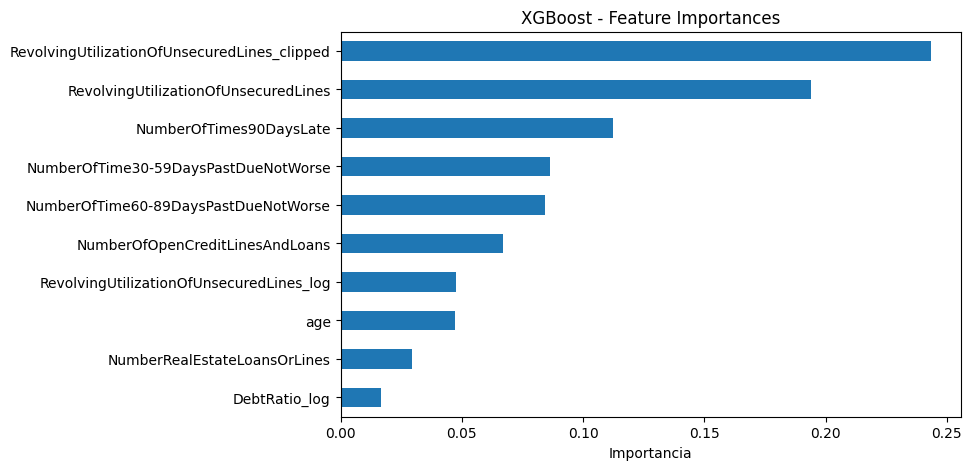

 2. Calculando Permutation Importance (en conjunto de test)...
  Top 10 Features (por Permutation Importance en F1):
                             feature  importance_mean
             NumberOfTimes90DaysLate         0.038661
NumberOfTime30-59DaysPastDueNotWorse         0.020728
NumberOfTime60-89DaysPastDueNotWorse         0.014741
     NumberOfOpenCreditLinesAndLoans         0.003443
                       MonthlyIncome         0.002909
                   DebtRatio_clipped         0.000398
                       DebtRatio_log         0.000292
                    MonthlyIncome_na         0.000021
               NumberOfDependents_na         0.000000
                  NumberOfDependents        -0.000114
 3. Calculando valores SHAP (en una muestra de test)...
  Generando SHAP summary plot...
  Top 10 Features (por Permutation Importance en F1):
                             feature  importance_mean
             NumberOfTimes90DaysLate         0.038661
NumberOfTime30-59DaysPastDueNotWorse  

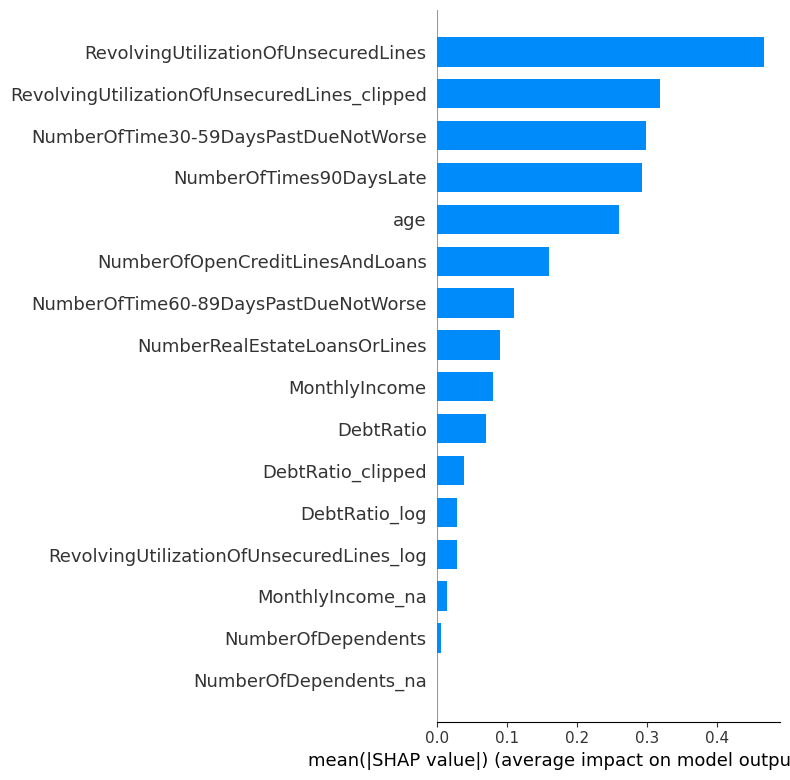

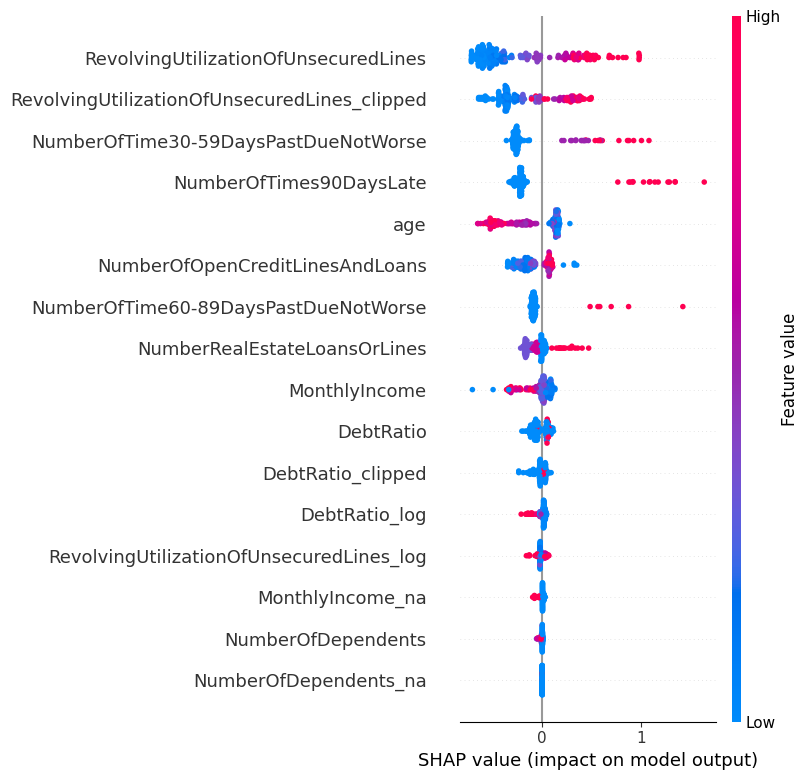


------------------------------------------------------------
Analizando Modelo: LOGISTICREGRESSION
------------------------------------------------------------
Mejores Parámetros: {'clf__C': np.float64(10.0), 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

 Entrenando pipeline final en datos de entrenamiento completos...

 1. Analizando Importancia de Características Nativas
  Top 10 Features (por magnitud de coeficiente):
RevolvingUtilizationOfUnsecuredLines_clipped    0.390597
RevolvingUtilizationOfUnsecuredLines_log        0.357525
NumberOfTimes90DaysLate                         0.319302
MonthlyIncome                                  -0.294484
NumberOfTime30-59DaysPastDueNotWorse            0.285256
age                                            -0.251413
NumberOfTime60-89DaysPastDueNotWorse            0.206657
MonthlyIncome_na                                0.151818
NumberOfOpenCreditLinesAndLoans                 0.141023
NumberRealEstateLoansOrLines                    0.123306
 2.

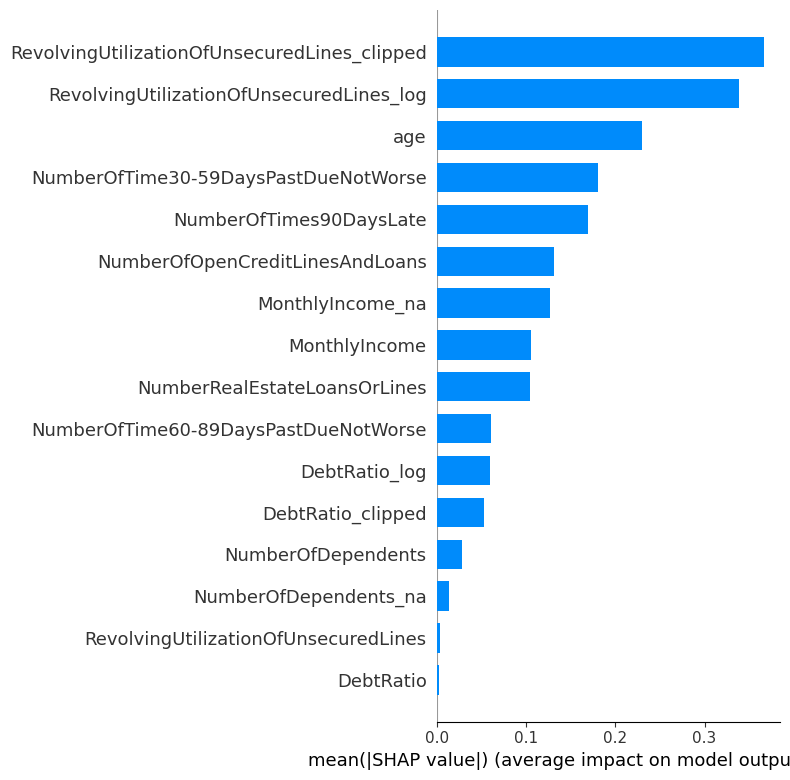

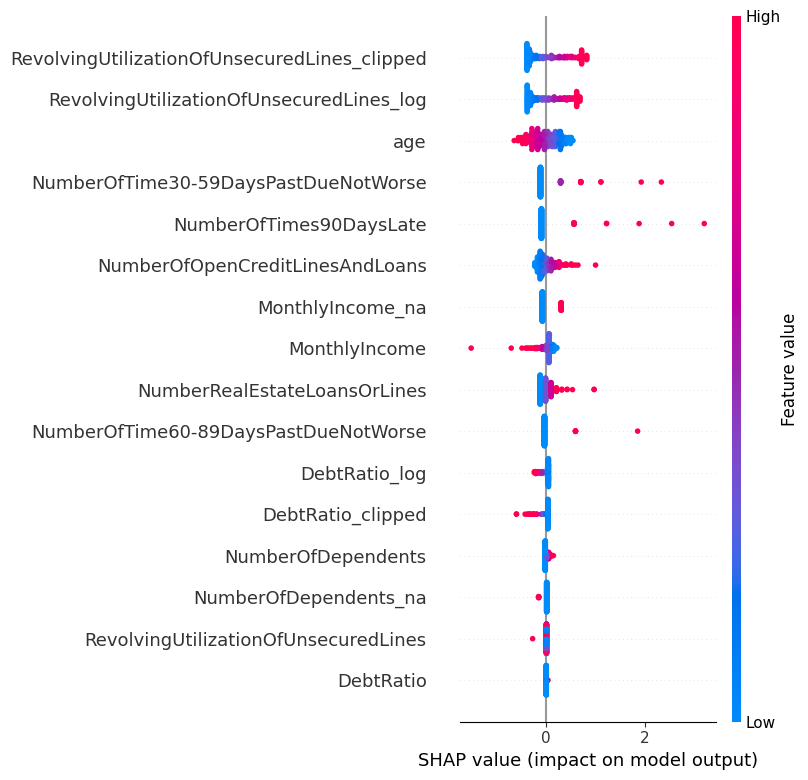


------------------------------------------------------------
Analizando Modelo: LINEARSVC
------------------------------------------------------------
Mejores Parámetros: {'clf__C': np.float64(0.001), 'clf__class_weight': None, 'clf__loss': 'squared_hinge'}

 Entrenando pipeline final en datos de entrenamiento completos...

 1. Analizando Importancia de Características Nativas
  Top 10 Features (por magnitud de coeficiente):
RevolvingUtilizationOfUnsecuredLines_clipped    0.165843
NumberOfTimes90DaysLate                         0.107751
RevolvingUtilizationOfUnsecuredLines_log       -0.083267
NumberOfTime30-59DaysPastDueNotWorse            0.069194
NumberOfTime60-89DaysPastDueNotWorse            0.065753
MonthlyIncome                                  -0.034326
age                                            -0.022388
MonthlyIncome_na                                0.021644
DebtRatio_clipped                              -0.015785
NumberRealEstateLoansOrLines                    0.015349


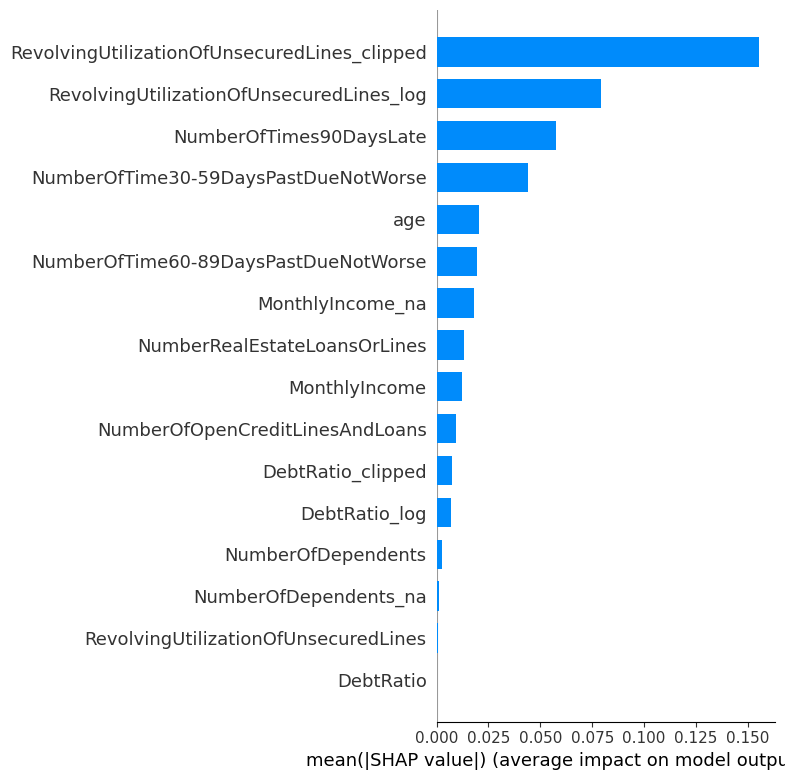

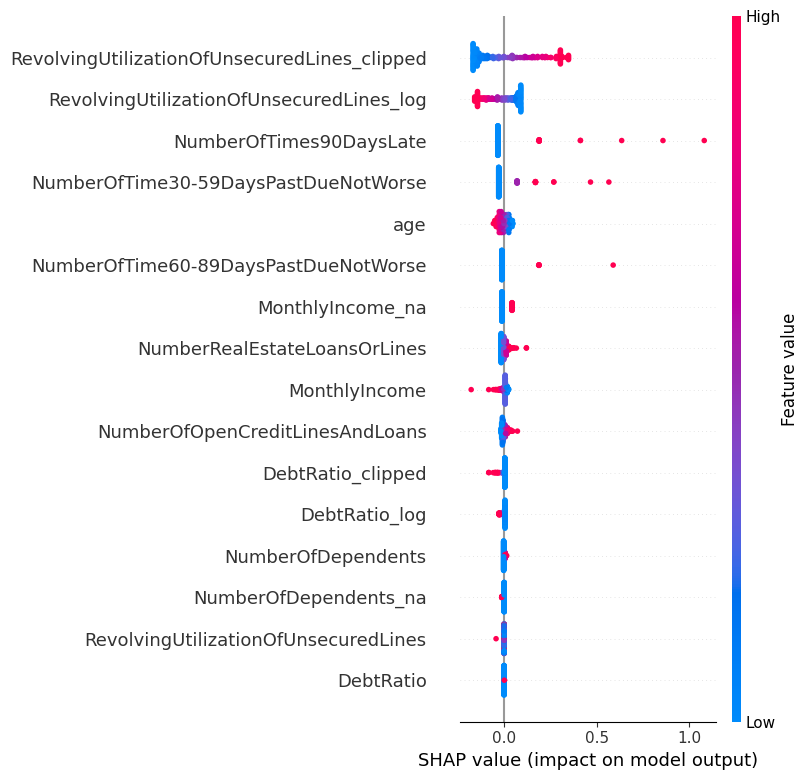


ANÁLISIS DE INTERPRETABILIDAD COMPLETADO


In [48]:
print('INICIANDO ANÁLISIS DE INTERPRETABILIDAD DE LOS TOP 3 MODELOS')

if 'results_df' not in locals() or results_df.empty:
    print("DataFrame de resultados no encontrado. Ejecuta la celda de ranking final primero.")
else:
    # Seleccionar los 3 mejores modelos basados en el ranking previo
    top_3_models_df = results_df.head(3)
    
    # Diccionario para guardar los pipelines finales entrenados
    trained_pipelines = {}

    for _, row in top_3_models_df.iterrows():
        model_label = row['model']
        
        best_params = row['best_params']
        
        print(f'\n{"---"*20}\nAnalizando Modelo: {model_label.upper()}\n{"---"*20}')
        print(f'Mejores Parámetros: {best_params}')

        # --- Reconstrucción del Pipeline ---
        if 'Logistic' in model_label:
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
            ])
        elif 'XGBoost' in model_label:
            pipe = ImbPipeline([
                ('smote', SMOTE(random_state=RANDOM_STATE)),
                ('scaler', StandardScaler()),
                ('clf', XGBClassifier(tree_method='hist', random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'))
            ])
        elif 'RandomForest' in model_label:
            pipe = ImbPipeline([
                ('smote', SMOTE(random_state=RANDOM_STATE)),
                ('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
            ])
        elif 'LinearSVC' in model_label:
             pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', LinearSVC(max_iter=3000, random_state=RANDOM_STATE))
            ])
        else:
            print(f"  > Modelo '{model_label}' no reconocido para reconstrucción. Saltando.")
            continue
            
        # Aplicar los mejores parámetros al pipeline reconstruido
        pipe.set_params(**best_params)
        
        # Entrenar en el conjunto de entrenamiento completo
        print("\n Entrenando pipeline final en datos de entrenamiento completos...")
        pipe.fit(X_train, y_train)
        trained_pipelines[model_label] = pipe
        
        # Extraer el clasificador final del pipeline
        clf = pipe.named_steps['clf']
        
        # --- 1. Importancia de Características Nativas ---
        print("\n 1. Analizando Importancia de Características Nativas")
        if hasattr(clf, 'coef_'):
            # Lógica para modelos lineales
            feature_imp = pd.Series(clf.coef_[0], index=X_train.columns).sort_values(key=abs, ascending=False)
            print("  Top 10 Features (por magnitud de coeficiente):")
            print(feature_imp.head(10).to_string())
            
        elif hasattr(clf, 'feature_importances_'):
            # Lógica para modelos de árboles
            feature_imp = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            print("  Top 10 Features (por importancia Gini/Ganancia):")
            print(feature_imp.head(10).to_string())
            
            # Visualización
            plt.figure(figsize=(8, 5))
            feature_imp.head(10).sort_values().plot(kind='barh', title=f'{model_label} - Feature Importances')
            plt.xlabel("Importancia")
            plt.show()

        # --- 2. Permutation Importance ---
        print(" 2. Calculando Permutation Importance (en conjunto de test)...")
        perm_imp = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=5, # Reducido para velocidad
            random_state=RANDOM_STATE, 
            scoring='f1', # Usamos F1, nuestra métrica de negocio
            n_jobs=-1
        )
        perm_df = pd.DataFrame({
            'feature': X_test.columns,
            'importance_mean': perm_imp.importances_mean,
        }).sort_values('importance_mean', ascending=False)
        
        print('  Top 10 Features (por Permutation Importance en F1):')
        print(perm_df.head(10).to_string(index=False))

        # --- 3. SHAP ---
        if _dependencies.get('SHAP', False):
            print(" 3. Calculando valores SHAP (en una muestra de test)...")
            try:
                # Preprocesar datos para SHAP: solo escalamos, no aplicamos SMOTE
                scaler = pipe.named_steps['scaler']
                X_test_scaled = scaler.transform(X_test.fillna(0))
                X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
                
                # Usar una muestra para velocidad
                X_shap_sample = X_test_scaled_df.sample(200, random_state=RANDOM_STATE)
                
                # Crear el explainer adecuado
                if hasattr(clf, 'coef_'): # Lineal
                    explainer = shap.LinearExplainer(clf, X_shap_sample)
                else: # Árbol
                    explainer = shap.TreeExplainer(clf)
                
                shap_values = explainer(X_shap_sample)
                
                # Gráfico de resumen
                print("  Generando SHAP summary plot...")
                shap.summary_plot(shap_values, X_shap_sample, plot_type="bar", title=f"SHAP Summary - {model_label}")
                plt.show()
                shap.summary_plot(shap_values, X_shap_sample, title=f"SHAP Summary - {model_label}")
                plt.show()
                
            except Exception as e:
                print(f' Error calculando SHAP para {model_label}: {e}')
                
print(f'\n{"="*80}')
print('ANÁLISIS DE INTERPRETABILIDAD COMPLETADO')
print("="*80)

# 8. Visualización Final y Exportación

Resumen visual de resultados con paleta roja y exportación de configuraciones finales.

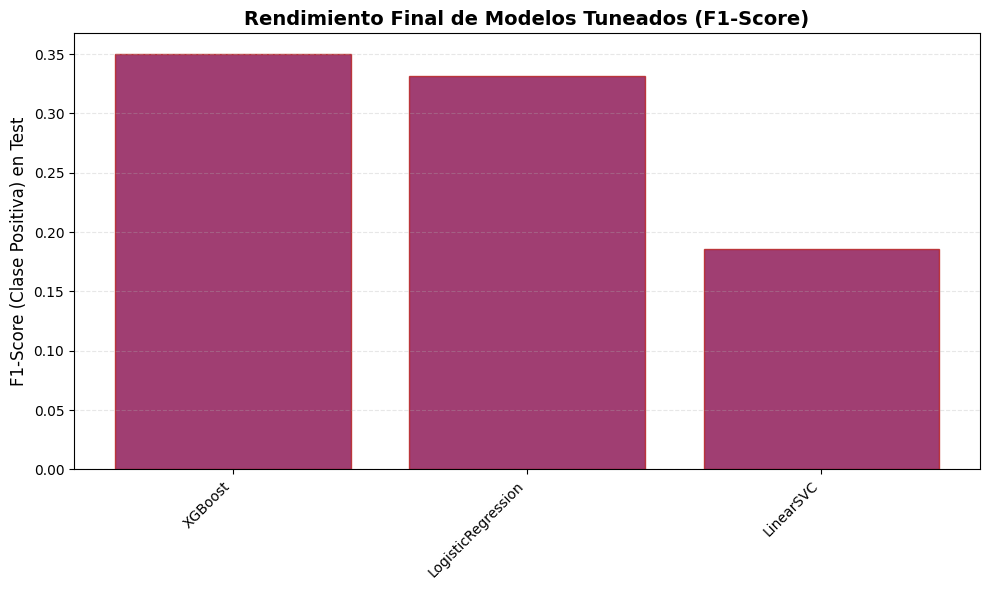

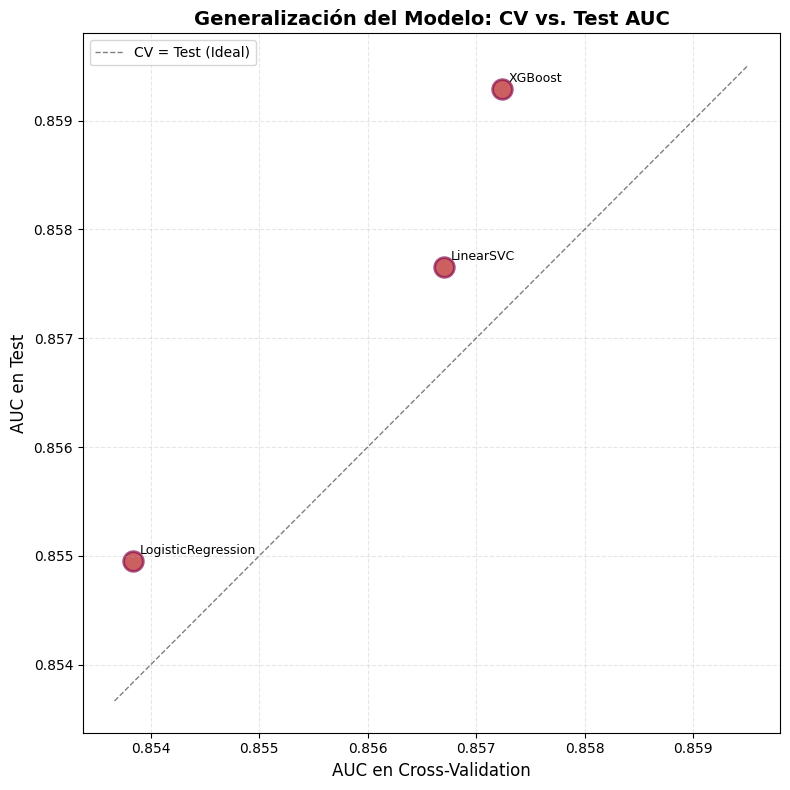

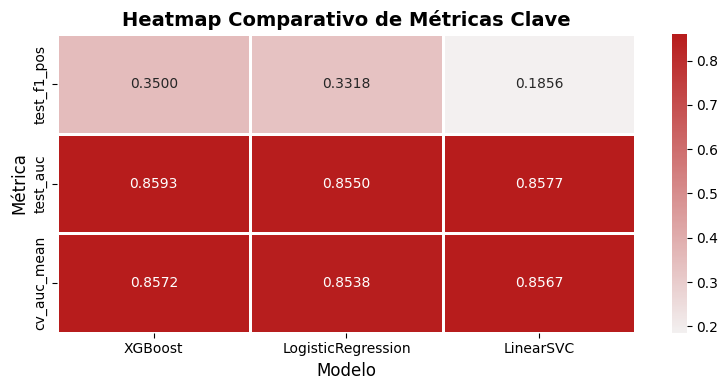


✓ Mejores configuraciones exportadas a: C:\\MachineLearningPG\reports\tuning_best_params.json


In [49]:
if 'results_df' not in locals() or results_df.empty:
    print(" DataFrame de resultados no encontrado. Ejecuta la celda de ranking final primero.")
else:
    # Preparación de Datos para Visualización
    plot_df = results_df.copy()
    
    # Cambiamos 'label' por 'model' y 'cv_auc_mean' por 'cv_auc'
    plot_df = plot_df.rename(columns={'model': 'label', 'cv_auc': 'cv_auc_mean'})
    
    if 'cv_auc_std' not in plot_df.columns:
        plot_df['cv_auc_std'] = 0.001 # Un pequeño valor por defecto
        
    # Ordenar por F1-score para que los gráficos sean más intuitivos
    plot_df = plot_df.sort_values('test_f1_pos', ascending=False)
    
    # --- Visualización 1: Barplot de F1-Score en Test ---
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(plot_df['label'], plot_df['test_f1_pos'], 
                  color='#880e4f', edgecolor='#b71c1c', alpha=0.8)
    ax.set_xticklabels(plot_df['label'], rotation=45, ha='right')
    ax.set_ylabel('F1-Score (Clase Positiva) en Test', fontsize=12)
    ax.set_title('Rendimiento Final de Modelos Tuneados (F1-Score)', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    # --- Visualización 2: Scatter CV AUC vs Test AUC ---
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(plot_df['cv_auc_mean'], plot_df['test_auc'], 
               s=200, c='#b71c1c', alpha=0.7, edgecolors='#880e4f', linewidths=2)
    for _, row in plot_df.iterrows():
        ax.annotate(row['label'], (row['cv_auc_mean'], row['test_auc']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=1, label='CV = Test (Ideal)')
    ax.set_xlabel('AUC en Cross-Validation', fontsize=12)
    ax.set_ylabel('AUC en Test', fontsize=12)
    ax.set_title('Generalización del Modelo: CV vs. Test AUC', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # --- Visualización 3: Heatmap de Métricas ---
    metrics_cols = ['test_f1_pos', 'test_auc', 'cv_auc_mean']
    heatmap_data = plot_df[['label'] + metrics_cols].set_index('label')
    plt.figure(figsize=(8, 4))
    sns.heatmap(heatmap_data.T, annot=True, fmt='.4f', cmap=sns.light_palette('#b71c1c', as_cmap=True),
                linewidths=1, linecolor='white')
    plt.title('Heatmap Comparativo de Métricas Clave', fontsize=14, fontweight='bold')
    plt.xlabel('Modelo', fontsize=12)
    plt.ylabel('Métrica', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # --- Exportación de Mejores Configuraciones ---
    best_params_export = {}
    for _, row in results_df.iterrows():
        model_name = row['model']
        best_params_export[model_name] = {
            'best_params': row['best_params'],
            'cv_auc': float(row['cv_auc']),
            'test_auc': float(row['test_auc']),
            'test_f1_pos': float(row['test_f1_pos'])
        }

    output_path = os.path.join(REPORTS_DIR, 'tuning_best_params.json')
    with open(output_path, 'w') as f:
        json.dump(best_params_export, f, indent=2, default=str) # Añadido default=str por si hay tipos no serializables
    print(f'\n✓ Mejores configuraciones exportadas a: {output_path}')
    

### El modelo de XGBoost será nuestro modelo propuesto